# Service Base Segmentation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from common.src.main.python.utils.hdfs_generic import *
import os
MAX_N_EXECUTORS=20

MIN_N_EXECUTORS=2
N_CORES_EXECUTOR=4
EXECUTOR_IDLE_MAX_TIME=120
EXECUTOR_MEMORY='16g'
DRIVER_MEMORY='26g'
N_CORES_DRIVER=1
MEMORY_OVERHEAD=N_CORES_EXECUTOR*2048
QUEUE="root.BDPtenants.es.medium"
BDA_CORE_VERSION="1.0.0"

SPARK_COMMON_OPTS=os.environ.get('SPARK_COMMON_OPTS', '')
SPARK_COMMON_OPTS+=" --executor-memory %s --driver-memory %s" % (EXECUTOR_MEMORY, DRIVER_MEMORY)
SPARK_COMMON_OPTS+=" --conf spark.shuffle.manager=tungsten-sort"
SPARK_COMMON_OPTS+="  --queue %s" % QUEUE
app_name='mobile apps segmentation'
SPARK_COMMON_OPTS += " --conf spark.app.name='%s'" % (app_name)


# Dynamic allocation configuration
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=500"
SPARK_COMMON_OPTS+=" --conf spark.shuffle.service.enabled=true"
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.maxExecutors=%s" % (MAX_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.minExecutors=%s" % (MIN_N_EXECUTORS)
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.executorIdleTimeout=%s" % (EXECUTOR_IDLE_MAX_TIME)




BDA_ENV = os.environ.get('BDA_USER_HOME', '')

#opciones jmarcoso
SPARK_COMMON_OPTS+=" --conf spark.dynamicAllocation.initialExecutors=10"
SPARK_COMMON_OPTS+=" --conf spark.yarn.am.waitTime=800000s"
SPARK_COMMON_OPTS+=" --conf spark.network.timeout=10000001"
SPARK_COMMON_OPTS+=" --conf spark.executor.heartbeatInterval=10000000"
SPARK_COMMON_OPTS+=" --conf spark.executor.cores=4"
SPARK_COMMON_OPTS+=" --conf spark.port.maxRetries=500"
SPARK_COMMON_OPTS+=" --conf spark.sql.shuffle.partitions=1000"





# Attach bda-core-ra codebase
# SPARK_COMMON_OPTS+=" --files \
# {}/scripts/properties/red_agent/nodes.properties,\
# {}/scripts/properties/red_agent/nodes-de.properties,\
# {}/scripts/properties/red_agent/nodes-es.properties,\
# {}/scripts/properties/red_agent/nodes-ie.properties,\
# {}/scripts/properties/red_agent/nodes-it.properties,\
# {}/scripts/properties/red_agent/nodes-pt.properties,\
# {}/scripts/properties/red_agent/nodes-uk.properties".format(*[BDA_ENV]*7)

os.environ["SPARK_COMMON_OPTS"] = SPARK_COMMON_OPTS
os.environ["PYSPARK_SUBMIT_ARGS"] = "%s pyspark-shell " % SPARK_COMMON_OPTS

#print os.environ.get('SPARK_COMMON_OPTS', '')
#print os.environ.get('PYSPARK_SUBMIT_ARGS', '')

sc, sparkSession, sqlContext = run_sc()

In [3]:
from common.src.main.python.utils.hdfs_generic import *
from pyspark.sql.functions import  (sum as sql_sum, countDistinct, trim
                                    ,max as sql_max, min as sql_min , split,desc, col, current_date
                                    , datediff, lit, translate, udf
                                    , when, concat_ws, concat, decode, length
                                    , substring, to_date, regexp_replace, lpad
                                    , hour, date_format
                                   , expr, coalesce,  year, month, minute
                                    ,count, dayofmonth, conv, upper)
from pyspark.sql.window import Window
import pyspark.sql.functions as func
import datetime, time


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
spark = (SparkSession.builder
         .appName("Mobile Apps Segmentation")
         .master("yarn")
         .config("spark.submit.deployMode", "client")
         .config("spark.ui.showConsoleProgress", "true")
         .enableHiveSupport()
         .getOrCreate()
         )

We aim to provide a segmentation based on internet usage (Netscout) and Video on Demand (VoD, ARRIS)

In [5]:
def prettySummary(df):
    """ Neat summary statistics of a Spark dataframe
    Args:
        pyspark.sql.dataframe.DataFrame (df): input dataframe
    Returns:
        pandas.core.frame.DataFrame: a pandas dataframe with the summary statistics of df
    """
    import pandas as pd
    temp = df.describe().toPandas()
    temp.iloc[1:3,1:] = temp.iloc[1:3,1:].convert_objects(convert_numeric=True)
    pd.options.display.float_format = '{:,.2f}'.format
    return temp

def saveDF(path, df, partitions):
    print('[' + time.ctime() + '] ' + 'Saving started in: ' + path)
    df.repartition(partitions).write.mode('overwrite').format('parquet').save(path)
    #df.write.mode('overwrite').format('parquet').save(path)
    print('[' + time.ctime() + '] ' + 'Saving finished!')


# Mobile Apps Segmentation

Our main goal is to develop an individual segmentation based on applications usage

In [6]:
HDFS_READ_COMMON = '/data/udf/vf_es/amdocs_inf_dataset/'
HDFS_READ_COMMON = '/user/bbergua/amdocs_inf_dataset/'
HDFS_READ_COMMON = '/data/udf/vf_es/amdocs_ids/'
PATH_READ_FULL = HDFS_READ_COMMON + 'service/'

closing_day='20200430'

hdfs_partition_path = 'year=' + str(int(closing_day[:4])) + '/month=' + str(int(closing_day[4:6])) + '/day=' + str(int(closing_day[6:8]))
path_ids = PATH_READ_FULL + hdfs_partition_path
dataframe_raw = (spark.read.load(path_ids))

hdfs_partition_path

path_netscout_apps = '/data/udf/vf_es/amdocs_ids/netscout_apps/'+hdfs_partition_path
df_netscout_apps=(spark.read.load(path_netscout_apps))

dataframe_raw = \
(dataframe_raw
.join(df_netscout_apps, 'msisdn', 'leftouter')
)

In [7]:
apps_to_use=['YOUTUBE','INSTAGRAM','FACEBOOK','WHATSAPP','TWITTER','TRAVEL','SPOTIFY','SNAPCHAT','NETFLIX'
            ,'GAMBLING','DATING','SPORTS', 'AMAZON']

In [8]:
netscout_cols=[]

for x in apps_to_use:
        netscout_cols += [c for c in dataframe_raw.columns if (('NS_APPS' in c) & (('data_mb' in c)|('days' in c)) & (x in c)
                                                                   & ('MESSAGE' not in c) & ('VIDEO' not in c) 
                                                                   & ('CALLING' not in c) 
                                                                   )  ]
#        netscout_days_cols += [c for c in dataframe_raw.columns if (('NS_APPS' in c) & ('days' in c) & (x in c)
#                                                                   & ('MESSAGE' not in c) & ('VIDEO' not in c) 
#                                                                   & ('CALLING' not in c) 
#                                                                   )]
#

In [9]:
netscout_cols

['NS_APPS_YOUTUBE_data_mb',
 'NS_APPS_YOUTUBE_days',
 'NS_APPS_INSTAGRAM_data_mb',
 'NS_APPS_INSTAGRAM_days',
 'NS_APPS_FACEBOOK_data_mb',
 'NS_APPS_FACEBOOK_days',
 'NS_APPS_WHATSAPP_data_mb',
 'NS_APPS_WHATSAPP_days',
 'NS_APPS_TWITTER_data_mb',
 'NS_APPS_TWITTER_days',
 'NS_APPS_TRAVEL_data_mb',
 'NS_APPS_TRAVEL_days',
 'NS_APPS_SPOTIFY_data_mb',
 'NS_APPS_SPOTIFY_days',
 'NS_APPS_SNAPCHAT_data_mb',
 'NS_APPS_SNAPCHAT_days',
 'NS_APPS_NETFLIX_data_mb',
 'NS_APPS_NETFLIX_days',
 'NS_APPS_GAMBLING_data_mb',
 'NS_APPS_GAMBLING_days',
 'NS_APPS_DATING_data_mb',
 'NS_APPS_DATING_days',
 'NS_APPS_SPORTS_data_mb',
 'NS_APPS_SPORTS_days',
 'NS_APPS_AMAZON_data_mb',
 'NS_APPS_AMAZON_days']

In [10]:
'Serv_rgu' in dataframe_raw.columns

False

In [11]:
clustering_df=(dataframe_raw[['msisdn']+netscout_cols]
               .where(col('RGU').isin(['prepaid', 'mobile']))
               .withColumn('IDENT_NS',when(col('NS_APPS_YOUTUBE_days').isNull(),0).otherwise(1))
               .where(col('IDENT_NS')==1)
               .fillna(0)
              )

### Assemble and scale

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

vecAssembler = VectorAssembler(inputCols=clustering_df.columns[1:], outputCol="features")
clustering_df_assembled = vecAssembler.transform(clustering_df)

standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='std_features')

model = standardizer.fit(clustering_df_assembled)

clustering_df_assembled_scaled = model.transform(clustering_df_assembled)

### KMeans - Model Training


Kmeans trained algorithm should not be executed every month as segments are expected to remain characteristics in time enabling the study of the evolution of the segments during time.

Last execution: 20200407


In [13]:
from pyspark.sql import Row
from pyspark.ml.clustering import KMeans, KMeansModel
n_clusters = 4
kmeans = KMeans(featuresCol='std_features',k=n_clusters)
modelKMeans = kmeans.fit(clustering_df_assembled_scaled)

In [14]:
# # saving the model
# 
path_model_works_base='/user/avazq108/models_prod/'
path_model_works_model=path_model_works_base+'model_definition/netscout_apps_segm/'+ hdfs_partition_path
modelKMeans.write().overwrite().save(path_model_works_model)

### KMeans - Load and Execution


In [15]:
from pyspark.ml.clustering import KMeans, KMeansModel

closing_day_trained_model=closing_day

hdfs_partition_path_model = 'year=' + str(int(closing_day_trained_model[:4])) + '/month=' + str(int(closing_day_trained_model[4:6])) + '/day=' + str(int(closing_day_trained_model[6:8]))

#path_model_works_base='/user/rbuendi1/models_prod/'
path_model_works_model=path_model_works_base+'model_definition/netscout_apps_segm/'+ hdfs_partition_path_model
modelKMeans_cargado = KMeansModel.load(path_model_works_model)

In [16]:
transformed = modelKMeans_cargado.transform(clustering_df_assembled_scaled).drop(*['features','std_features'])
transformed.groupBy('prediction').count().show()

+----------+-------+
|prediction|  count|
+----------+-------+
|         1| 431628|
|         3|2064845|
|         2|    241|
|         0|4085275|
+----------+-------+



## Results Analysis

In [17]:
stats_df_0=prettySummary(transformed.filter(transformed.prediction==0).drop('prediction'))
stats_df_1=prettySummary(transformed.filter(transformed.prediction==1).drop('prediction'))
stats_df_2=prettySummary(transformed.filter(transformed.prediction==2).drop('prediction'))
stats_df_3=prettySummary(transformed.filter(transformed.prediction==3).drop('prediction'))

stats_df_0['cluster']=0
stats_df_1['cluster']=1
stats_df_2['cluster']=2
stats_df_3['cluster']=3

frames = [  stats_df_0[stats_df_0.summary=='mean']
          , stats_df_1[stats_df_1.summary=='mean']
          , stats_df_2[stats_df_2.summary=='mean']
          , stats_df_3[stats_df_3.summary=='mean']]

result = pd.concat(frames)

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # Remove the CWD from sys.path while we load stuff.


In [18]:

for c in netscout_cols:
    new_col=c+'_perc'
    result[new_col]=result[c]/result[c].sum()
    


In [19]:
#result.transpose().style.bar( color='#d65f5f')

In [20]:
counts=transformed.groupBy('prediction').count().toPandas()
result_final = pd.merge(result, counts, left_on='cluster', right_on='prediction')

In [21]:
#result_final.style.bar( color='#d65f5f')
#result_final[result_final['prediction']==0].apply(pd.to_numeric, errors='coerce').dtypes
#ns_contents_data
result_final=result_final.apply(pd.to_numeric, errors='coerce')

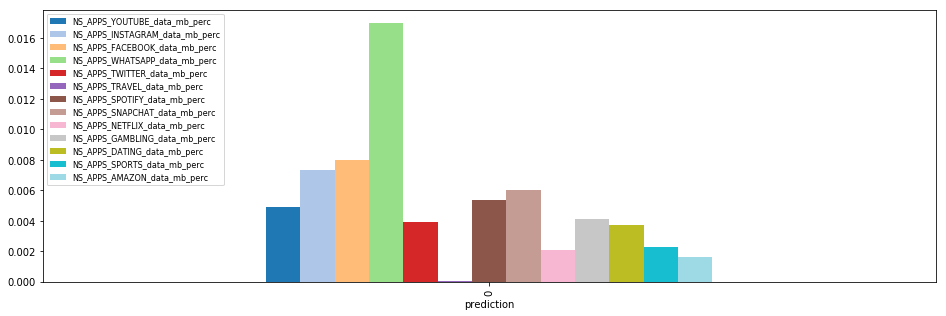

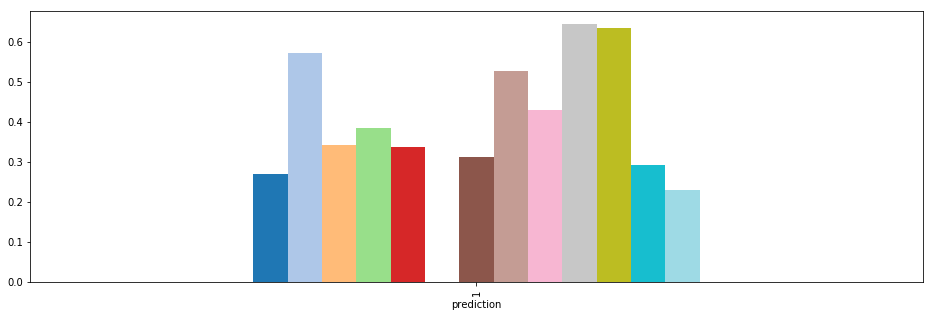

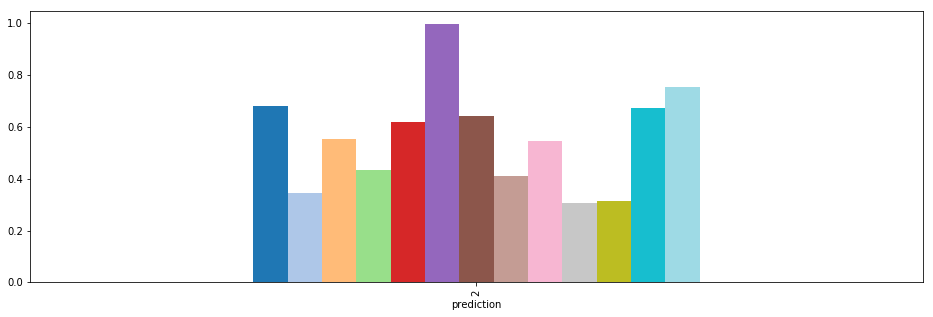

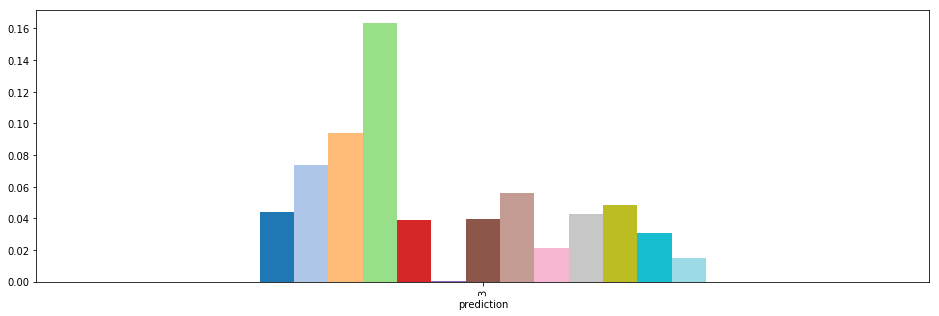

In [22]:
ns_contents_days = [columna for columna in result_final.columns if 'days_perc' in columna]
ns_contents_data = [columna for columna in result_final.columns if 'data_mb_perc' in columna]
from matplotlib.pyplot import *
fig, ax = subplots()
result_final[result_final['prediction']==0].plot(kind='bar', x='prediction' , y=ns_contents_data , figsize=(16,5), colormap='tab20' , ax=ax)
result_final[result_final['prediction']==1].plot(kind='bar', x='prediction' , y=ns_contents_data , figsize=(16,5), colormap='tab20' ,legend=False )
result_final[result_final['prediction']==2].plot(kind='bar', x='prediction' , y=ns_contents_data , figsize=(16,5), colormap='tab20' ,legend=False)
result_final[result_final['prediction']==3].plot(kind='bar', x='prediction' , y=ns_contents_data , figsize=(16,5), colormap='tab20' ,legend=False)
ax.legend( loc='upper left',prop={'size': 8})


#result_final[result_final['prediction']==1].plot(kind='bar', x=['prediction_name'] , y=ns_contents_data , figsize=(16,5), colormap='Vega20c')
#result_final[result_final['prediction']==2].plot(kind='bar', x=['prediction_name'] , y=ns_contents_data , figsize=(16,5), colormap='Vega20c')
#result_final[result_final['prediction']==3].plot(kind='bar', x=['prediction_name'] , y=ns_contents_data , figsize=(16,5), colormap='Vega20c')



In [23]:
result_final['prediction_name']='none'
result_final['prediction_name'][result_final['prediction'] == 2] = 'Heavy Sports Games'
result_final['prediction_name'][result_final['prediction'] == 1] = 'Regular'
result_final['prediction_name'][result_final['prediction'] == 0] = 'Heavy Social'
result_final['prediction_name'][result_final['prediction'] == 3] = 'Low Usage'

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a

# End Analysis

# Export Data

In [24]:
export_df_tmp1=(transformed
           .withColumnRenamed('prediction','id_segment')
           .withColumn('name_segment',when(col('id_segment')==2,'Heavy Sports Games')
                                .when(col('id_segment')==1,'Regular')
                                .when(col('id_segment')==0,'Heavy Social')
                                .when(col('id_segment')==3,'Low Usage')
                                .otherwise(None))
           .withColumnRenamed('NS_APPS_GAMBLING_data_mb','NS_APPS_GAMES_data_mb')
           .withColumnRenamed('NS_APPS_GAMBLING_days','NS_APPS_GAMES_days')
           .withColumnRenamed('NS_APPS_SPORTS_data_mb','NS_APPS_DEPORTES_data_mb')
           .withColumnRenamed('NS_APPS_SPORTS_days','NS_APPS_DEPORTES_days')
           .drop('IDENT_NS')
           )


#oldColumns = export_df_tmp1.columns
#newColumns1 = [columna if 'data' in columna else columna for columna in oldColumns]
#newColumns2 = [columna[3:] if 'ns_' in columna else columna for columna in newColumns1]
#export_df_tmp2 = reduce(lambda export_df_tmp1, idx: export_df_tmp1.withColumnRenamed(oldColumns[idx], newColumns2[idx]), xrange(len(oldColumns)), export_df_tmp1)
export_df_tmp1.printSchema()

root
 |-- msisdn: string (nullable = true)
 |-- NS_APPS_YOUTUBE_data_mb: double (nullable = false)
 |-- NS_APPS_YOUTUBE_days: long (nullable = true)
 |-- NS_APPS_INSTAGRAM_data_mb: double (nullable = false)
 |-- NS_APPS_INSTAGRAM_days: long (nullable = true)
 |-- NS_APPS_FACEBOOK_data_mb: double (nullable = false)
 |-- NS_APPS_FACEBOOK_days: long (nullable = true)
 |-- NS_APPS_WHATSAPP_data_mb: double (nullable = false)
 |-- NS_APPS_WHATSAPP_days: long (nullable = true)
 |-- NS_APPS_TWITTER_data_mb: double (nullable = false)
 |-- NS_APPS_TWITTER_days: long (nullable = true)
 |-- NS_APPS_TRAVEL_data_mb: double (nullable = false)
 |-- NS_APPS_TRAVEL_days: long (nullable = true)
 |-- NS_APPS_SPOTIFY_data_mb: double (nullable = false)
 |-- NS_APPS_SPOTIFY_days: long (nullable = true)
 |-- NS_APPS_SNAPCHAT_data_mb: double (nullable = false)
 |-- NS_APPS_SNAPCHAT_days: long (nullable = true)
 |-- NS_APPS_NETFLIX_data_mb: double (nullable = false)
 |-- NS_APPS_NETFLIX_days: long (nullable = t

In [25]:
df_newColumns = [c[8:] if c not in ['msisdn', 'name_segment', 'id_segment']  else c for c in export_df_tmp1.columns]

export_df_tmp2 = export_df_tmp1.toDF(*df_newColumns)

In [26]:
current_timestamp = datetime.datetime.now()

In [27]:
path_hdfs_common = '/data/attributes/vf_es/return_feed/mobile_amdocs_apps_segmentation'
path_model_detail = path_hdfs_common + '/year=' + str(int(current_timestamp.year)) + '/month=' + str(int(current_timestamp.month)) + '/day=0'
path_model_detail

'/data/attributes/vf_es/return_feed/mobile_amdocs_apps_segmentation/year=2020/month=5/day=0'

In [28]:
#path = '/data/attributes/vf_es/return_feed/mobile_amdocs_apps_segmentation/year=2019/month=6/day=7'
#dataframe_raw = (spark.read.load(path))

In [29]:
from pyspark.sql.types import IntegerType

In [30]:
dataframe_renamed = \
(export_df_tmp2
 .withColumn('Youtube_days', col('YOUTUBE_days').cast(IntegerType()))
 .withColumnRenamed('YOUTUBE_data_mb','Youtube_data_mb')
 .withColumnRenamed('INSTAGRAM_data_mb','Instagram_data_mb')
 .withColumn('Instagram_days', col('INSTAGRAM_days').cast(IntegerType()))
 .withColumnRenamed('FACEBOOK_data_mb','Facebook_data_mb')
 .withColumn('Facebook_days', col('FACEBOOK_days').cast(IntegerType()))
 .withColumnRenamed('WHATSAPP_data_mb','Whatsapp_data_mb')
 .withColumn('Whatsapp_days', col('WHATSAPP_days').cast(IntegerType()))
 .withColumnRenamed('TWITTER_data_mb','Twitter_data_mb')
 .withColumn('Twitter_days', col('TWITTER_days').cast(IntegerType()))
 .withColumnRenamed('TRAVEL_data_mb','Travel_data_mb')
 .withColumn('Travel_days', col('TRAVEL_days').cast(IntegerType()))
 .withColumnRenamed('SPOTIFY_data_mb','spotify_data_mb')
 .withColumn('spotify_days', col('SPOTIFY_days').cast(IntegerType()))
 .withColumnRenamed('SNAPCHAT_data_mb','snapchat_data_mb')
 .withColumn('snapchat_days', col('SNAPCHAT_days').cast(IntegerType()))
 .withColumnRenamed('NETFLIX_data_mb','netflix_data_mb')
 .withColumn('netflix_days', col('NETFLIX_days').cast(IntegerType()))
 .withColumnRenamed('GAMES_data_mb','games_data_mb')
 .withColumn('games_days', col('GAMES_days').cast(IntegerType()))
 .withColumnRenamed('DATING_data_mb','dating_data_mb')
 .withColumn('dating_days', col('DATING_days').cast(IntegerType()))
 .withColumnRenamed('DEPORTES_data_mb','deportes_data_mb')
 .withColumn('deportes_days', col('DEPORTES_days').cast(IntegerType()))
)

In [30]:
dataframe_renamed.count()

6750283

In [31]:
dataframe_renamed.head()

Row(msisdn=u'600041651', Youtube_data_mb=1.0600652694702148, Youtube_days=5, Instagram_data_mb=0.25104808807373047, Instagram_days=3, Facebook_data_mb=0.3133087158203125, Facebook_days=8, Whatsapp_data_mb=4.397030830383301, Whatsapp_days=5, Twitter_data_mb=0.0, Twitter_days=0, Travel_data_mb=0.0, Travel_days=0, spotify_data_mb=0.0, spotify_days=0, snapchat_data_mb=0.0, snapchat_days=0, netflix_data_mb=0.0, netflix_days=0, games_data_mb=0.0, games_days=0, dating_data_mb=0.0, dating_days=0, deportes_data_mb=0.0, deportes_days=0, AMAZON_data_mb=0.0013027191162109375, AMAZON_days=1, id_segment=0, name_segment=u'Heavy Social')

In [31]:
dataframe_renamed.groupBy(col('name_segment')).count().show()

+------------------+-------+
|      name_segment|  count|
+------------------+-------+
|Heavy Sports Games|    241|
|           Regular| 431628|
|         Low Usage|2064845|
|      Heavy Social|4085275|
+------------------+-------+



In [32]:
path_model_detail

'/data/attributes/vf_es/return_feed/mobile_amdocs_apps_segmentation/year=2020/month=5/day=0'

## Adaptamos los resultados al formato `Model Outputs`:

In [33]:
dataframe_model_outputs = (dataframe_renamed
                           .withColumn('model_output', col('name_segment'))
                           .withColumn('extra_info', concat(lit("{ Youtube_data_mb= "), col('Youtube_data_mb'), lit("; Youtube_days= "), col("Youtube_days"),
                                                            lit("; Facebook_data_mb= "), col('Facebook_data_mb'), lit("; Facebook_days= "), col("Facebook_days"),
                                                            lit("; Instagram_data_mb= "), col("Instagram_data_mb"), lit("; Instagram_days= "), col("INSTAGRAM_days"),
                                                            lit("; Whatsapp_data_mb= "), col("Whatsapp_data_mb"), lit("; Whatsapp_days= "), col("Whatsapp_days"), 
                                                            lit("; Twitter_data_mb= "), col("Twitter_data_mb"), lit("; Twitter_days= "), col("Twitter_days"),
                                                            lit("; Travel_data_mb= "), col("Travel_data_mb"), lit("; Travel_days= "), col("Travel_days"), 
                                                            lit("; spotify_data_mb= "), col("spotify_data_mb"), lit("; spotify_days= "), col("spotify_days"),
                                                            lit("; snapchat_data_mb= "), col("snapchat_data_mb"), lit("; snapchat_days= "), col("snapchat_days"),
                                                            lit("; netflix_data_mb= "), col("netflix_data_mb"), lit("; netflix_days= "), col("netflix_days"),
                                                            lit("; games_data_mb= "), col("games_data_mb"), lit("; games_days= "), col("games_days"), 
                                                            lit("; dating_data_mb= "), col("dating_data_mb"), lit("; dating_days= "), col("dating_days"),
                                                            lit("; deportes_data_mb= "), col("deportes_data_mb"), lit("; deportes_days= "), col("deportes_days"), 
                                                            lit("; Amazon_data_mb= "), col("AMAZON_data_mb"), lit("; Amazon_days= "), col("AMAZON_days"), lit("}")
                                                           )
                                      )
                           .withColumn('prediction', col('id_segment'))
                          )

In [38]:
pd.set_option('max_colwidth', 10000)

In [34]:
level = 'msisdn'

model_name = 'service_base_segmentation'

path_model_detail = 'model_name=' + model_name \
                            + '/year=' + str(current_timestamp.year) \
                            + '/month=' + str(current_timestamp.month) \
                            + '/day=0'

path_model_outputs_base = '/data/attributes/vf_es/model_outputs/'
path_model_outputs_scores = path_model_outputs_base + 'model_scores/' + path_model_detail

In [35]:
path_model_outputs_scores

'/data/attributes/vf_es/model_outputs/model_scores/model_name=service_base_segmentation/year=2020/month=5/day=0'

In [36]:
executed_at = current_timestamp.strftime('%Y-%m-%d %H:%M:%S')
time = int(current_timestamp.strftime('%H%M%S'))

In [37]:
from pyspark.sql.types import DoubleType, StringType, IntegerType, ArrayType, FloatType

df_save_scores = (dataframe_model_outputs
                        # .withColumn('model_name',lit(model_name)) included in path
                        .withColumn('executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('model_executed_at', lit(executed_at).cast(StringType()))
                        .withColumn('predict_closing_date', lit(closing_day).cast(StringType()))
                        .withColumn('msisdn', col('msisdn').cast(StringType()))
                        .withColumn('client_id', lit(None).cast(StringType()))
                        .withColumn('nif', lit(None).cast(StringType()))
                        .withColumn('model_output', col('model_output').cast(StringType()))
                        .withColumn('scoring', lit(None).cast(FloatType()))
                        .withColumn('prediction', col('prediction').cast(StringType()))
                        .withColumn('extra_info', col('extra_info').cast(StringType()))
                        .withColumn('time', lit(time).cast(IntegerType()))
                        .withColumn('model_name', lit(model_name).cast(StringType()))
                        .select('executed_at', 'model_executed_at', 'predict_closing_date', 'msisdn'
                                       , 'client_id', 'nif', 'model_output', 'scoring', 'prediction'
                                       , 'extra_info', 'time')
                            )

In [38]:
df_save_scores.printSchema()

root
 |-- executed_at: string (nullable = false)
 |-- model_executed_at: string (nullable = false)
 |-- predict_closing_date: string (nullable = false)
 |-- msisdn: string (nullable = true)
 |-- client_id: string (nullable = true)
 |-- nif: string (nullable = true)
 |-- model_output: string (nullable = true)
 |-- scoring: float (nullable = true)
 |-- prediction: string (nullable = false)
 |-- extra_info: string (nullable = true)
 |-- time: integer (nullable = false)



In [39]:
def saveDF(path, df, partitions):
    print('Saving started in: %s', path)
    spark.conf.set("spark.sql.sources.partitionOverwriteMode","dynamic")
    df.repartition(partitions).write.mode('append').format('parquet').save(path)
    print('Saving finished!')

In [40]:
path_model_outputs_scores

'/data/attributes/vf_es/model_outputs/model_scores/model_name=service_base_segmentation/year=2020/month=5/day=0'

In [41]:
saveDF(path_model_outputs_scores, df_save_scores, 1)

('Saving started in: %s', '/data/attributes/vf_es/model_outputs/model_scores/model_name=service_base_segmentation/year=2020/month=5/day=0')
Saving finished!


# END.

In [42]:
test = spark.read.parquet('/data/attributes/vf_es/model_outputs/model_scores/model_name=service_base_segmentation/year=2020/month=5/day=0')

In [43]:
test_pandas = test.limit(20).toPandas()

In [44]:
test_pandas

,executed_at,model_executed_at,predict_closing_date,msisdn,client_id,nif,model_output,scoring,prediction,extra_info,time
0,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600009853,None,None,Regular,nan,1,{ Youtube_data_mb: 2680.331262588501; Youtube_...,165337
1,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600011304,None,None,Heavy Social,nan,0,{ Youtube_data_mb: 1.6828432083129883; Youtube...,165337
2,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600014226,None,None,Heavy Social,nan,0,{ Youtube_data_mb: 7.648468017578125E-4; Youtu...,165337
3,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600016724,None,None,Heavy Social,nan,0,{ Youtube_data_mb: 6.542178153991699; Youtube_...,165337
4,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600020405,None,None,Low Usage,nan,3,{ Youtube_data_mb: 1080.9922704696655; Youtube...,165337
5,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600085749,None,None,Low Usage,nan,3,{ Youtube_data_mb: 15.69263744354248; Youtube_...,165337
6,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600095998,None,None,Regular,nan,1,{ Youtube_data_mb: 10493.102875709534; Youtube...,165337
7,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600122370,None,None,Low Usage,nan,3,{ Youtube_data_mb: 17.979413986206055; Youtube...,165337
8,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600132256,None,None,Low Usage,nan,3,{ Youtube_data_mb: 585.1153955459595; Youtube_...,165337
9,2020-05-08 16:53:37,2020-05-08 16:53:37,20200430,600132730,None,None,Heavy Social,nan,0,{ Youtube_data_mb: 1.1074714660644531; Youtube...,165337


In [45]:
test_pandas.to_csv('sample_service_base_segmentation.csv', sep = ';', index = False)

In [46]:
spark.stop()